In [35]:
# from models import FCC, Siamese, Siamese_no_sharing
from models_v2 import FCC, Siamese
import dlc_practical_prologue
import torch
from torch import nn
from torch import optim
import torchvision
from torch.nn import functional as F
from tqdm import trange
import matplotlib.pyplot as plt
import models
# from utils import Proj1
import utils

In [2]:
# Load and pack data
train_input, train_target, train_classes, test_input, test_target, test_classes = dlc_practical_prologue.generate_pair_sets(1000)
train_data = (train_input, train_target, train_classes)
test_data = (test_input, test_target, test_classes)

# Instantiate models
models = (FCC(), FCC(share=True), FCC(aux=True), FCC(share=True, aux=True), Siamese(), Siamese(share=True), Siamese(aux=True), Siamese(share=True, aux=True))

model_names = ('FCC' , 'FCC with shared weights', 'FCC with auxiliary loss', 'FCC with auxiliary loss and shared weights',
               'Siamese without wwight sharing', 'Siamese with shared weights', 'Siamese with auxiliary loss', 'Siamese with auxiliary loss and shared weights')

In [3]:
# Define function that can evaluate all models
def evaluate_all(models, model_names, train_data, test_data, batch_size=100, rounds=10, epochs=25):
    # Unpack data
    train_input, train_target, train_classes = train_data
    test_input, test_target, test_classes = test_data
    # Initialize err rates arrays
    train_error_rates = torch.empty(rounds)
    test_error_rates = torch.empty(rounds)
    
    # Iterate models
    for model, name in zip(models, model_names):
        print(f'Training model {name} (contains {utils.count_parameters(model)}): ')
        # Iterate over r to get average
        for r in trange(rounds):
            # Call train_model with the correct parameters
            if 'Aux' in name:
                utils.train_model(model, train_input, train_target, batch_size, epochs, train_classes)
            else:
                utils.train_model(model, train_input, train_target, batch_size, epochs, train_classes=None)
            # Get error on train and test set
            train_error_rates[r] = utils.compute_nb_errors(model, train_input, train_target, batch_size)/train_input.size(0)
            test_error_rates[r] = utils.compute_nb_errors(model, test_input, test_target, batch_size)/test_input.size(0)
            
        #print(f'For the model {name}, the train average error rate is {train_error_rates.mean()} and the test average error rate {test_error_rates.mean()}\n')
        print('For the model {}, the train average error rate is {:.3}% and the test average error rate is {:.3}%.\n'
              .format(name, 100*train_error_rates.mean(), 100*test_error_rates.mean()))

In [4]:
# Actually evaluate models (this cell while take a while to run)
evaluate_all(models, model_names, train_data, test_data, batch_size=100, rounds=10, epochs=25)

  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

Training model FCC (contains 483618): 


  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

For the model FCC, the train average error rate is 0.17% and the test average error rate is 17.4%.

Training model FCC with shared weights (contains 483618): 


  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

For the model FCC with shared weights, the train average error rate is 0.06% and the test average error rate is 13.8%.

Training model FCC with auxiliary loss (contains 483618): 


  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

For the model FCC with auxiliary loss, the train average error rate is 0.08% and the test average error rate is 18.1%.

Training model FCC with auxiliary loss and shared weights (contains 483618): 


  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

For the model FCC with auxiliary loss and shared weights, the train average error rate is 0.02% and the test average error rate is 13.9%.

Training model Siamese without wwight sharing (contains 135480): 


  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

For the model Siamese without wwight sharing, the train average error rate is 1.65% and the test average error rate is 15.1%.

Training model Siamese with shared weights (contains 135480): 


  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

For the model Siamese with shared weights, the train average error rate is 2.45% and the test average error rate is 14.1%.

Training model Siamese with auxiliary loss (contains 135480): 


  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

For the model Siamese with auxiliary loss, the train average error rate is 2.9% and the test average error rate is 15.6%.

Training model Siamese with auxiliary loss and shared weights (contains 135480): 


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [01:15<00:00,  7.53s/it]

For the model Siamese with auxiliary loss and shared weights, the train average error rate is 2.53% and the test average error rate is 12.8%.



IndexError: index 8 is out of bounds for axis 0 with size 8

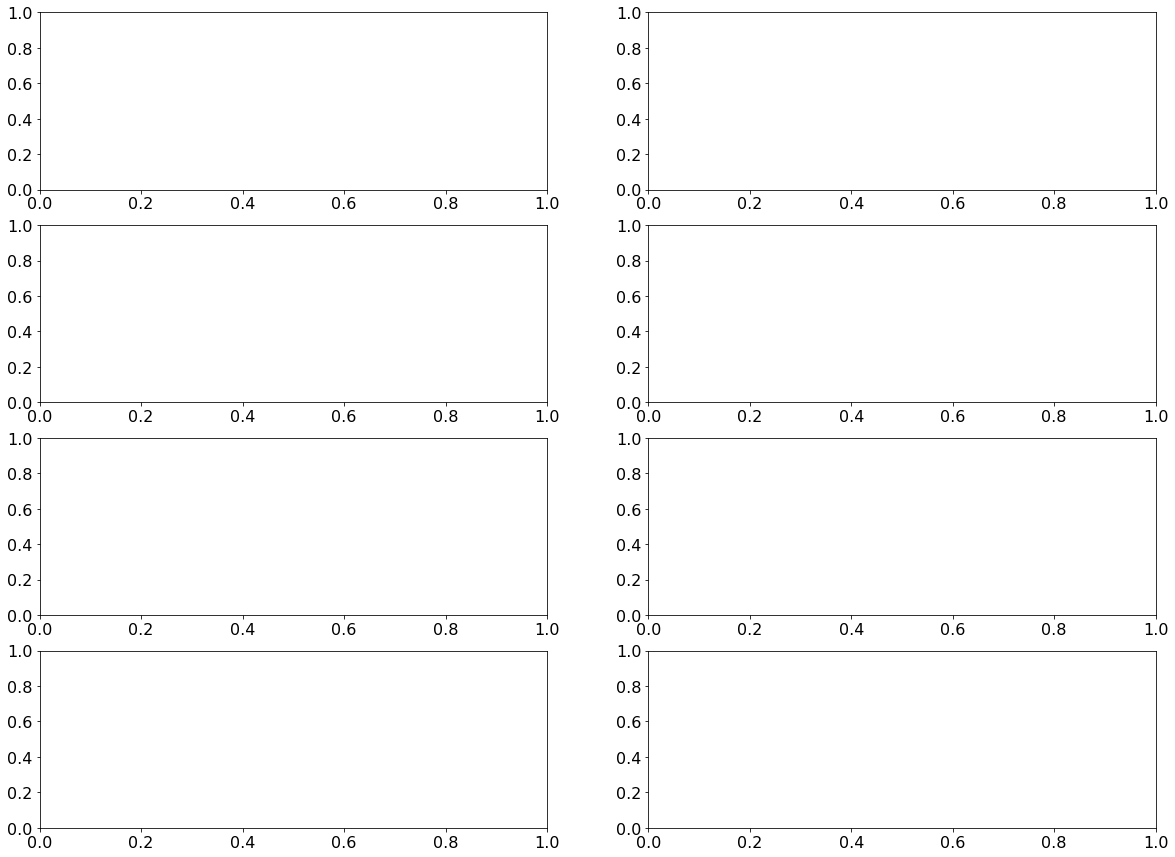

In [36]:
# Reinstantiate models to plot the evolution of accuracy and loss. 
models = (FCC(), FCC(share=True), FCC(aux=True), FCC(share=True, aux=True), 
          Siamese(), Siamese(share=True), Siamese(aux=True), Siamese(share=True, aux=True))

model_names = ('FCC' , 'FCC with Shared Weights', 'FCC with Auxiliary Loss', 'FCC with Auxiliary Loss and Shared Weights',
               'Siamese', 'Siamese with Shared Weights', 'Siamese with Auxiliary Loss', 'Siamese with Auxiliary Loss and Shared Weights')

# Initialize figure for report
mpl.rcParams.update({'font.size': 16})
fig, axs = plt.subplots(4, 2, figsize = (20, 15))
axs = axs.reshape(-1)
i = 0

# Iterate models
for model, model_name in zip(models, model_names):
    
    # Train model for 25 epochs
    losses = list(utils.train_model_track_errors(model, train_input, train_target, 100, 25, test_input, test_target, train_classes))
    train_loss, test_loss, train_acc, test_acc = losses
    
    # Plot loss
    ax_loss = axs[i]
    ax_loss.set_xlabel('Epochs')
    ax_loss.set_ylabel('Loss')
    ax_loss.set_title(model_name)
    p1 = ax_loss.plot(train_loss, 'r', label = 'Train Loss')
    p2 = ax_loss.plot(test_loss,  'b', label = 'Test Loss')
    
    ax_acc = ax_loss.twinx()  # instantiate a second axes that shares the same x-axis
    # Plot accuracy on twin axes
    ax_acc.set_ylabel('Accuracy')  # we already handled the x-label with ax1
    p3 = ax_acc.plot(test_acc, 'g', label = 'Test Accuracy')
    p4 = ax_acc.plot(train_acc, 'k', label = 'Train Accuracy')
    legends = [l.get_label() for l in p1+p2+p3+p4]
    ax_acc.grid()
    ax_acc.legend(p1+p2+p3+p4, legends)
    i += 1
# Make plot nice
fig.tight_layout()